# *Wait Listing FCFS, SJF, AI Swap-FCFS+Priority, Ticket Class wise, Priority-Based on attendance percentage, engagement levels, and behavior data for VIP and loyalty status.*

=== EXECUTING SCHEDULING ALGORITHMS ===

Executing FCFS Scheduling...
FCFS Scheduling completed successfully with 200 bookings
Executing Priority Scheduling...
Deadlock detected at time 122. Applying aging mechanism.
Deadlock detected at time 127. Applying aging mechanism.
Deadlock detected at time 136. Applying aging mechanism.
Deadlock detected at time 143. Applying aging mechanism.
Deadlock detected at time 145. Applying aging mechanism.
Deadlock detected at time 152. Applying aging mechanism.
Deadlock detected at time 160. Applying aging mechanism.
Deadlock detected at time 162. Applying aging mechanism.
Deadlock detected at time 170. Applying aging mechanism.
Deadlock detected at time 177. Applying aging mechanism.
Deadlock detected at time 179. Applying aging mechanism.
Deadlock detected at time 182. Applying aging mechanism.
Deadlock detected at time 184. Applying aging mechanism.
Deadlock detected at time 186. Applying aging mechanism.
Deadlock detected at time 187. Applying ag

<ipython-input-6-b454c8011ef6>:613: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(schedule))


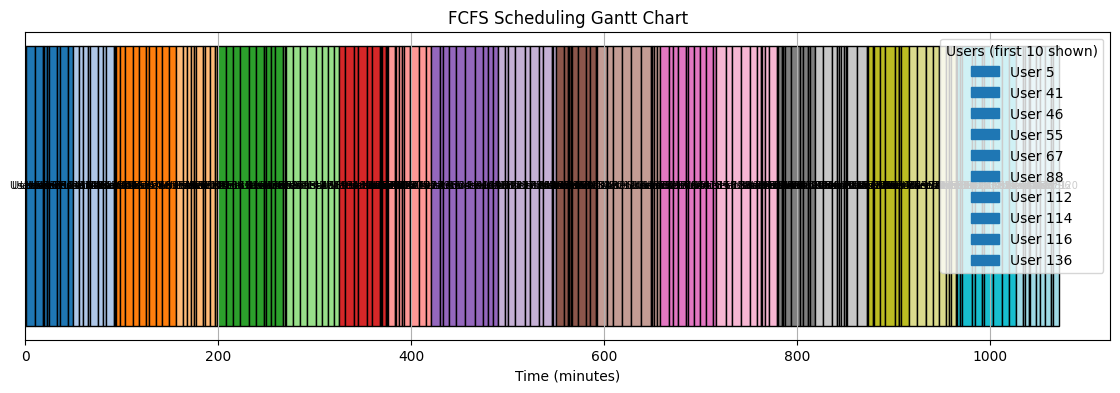

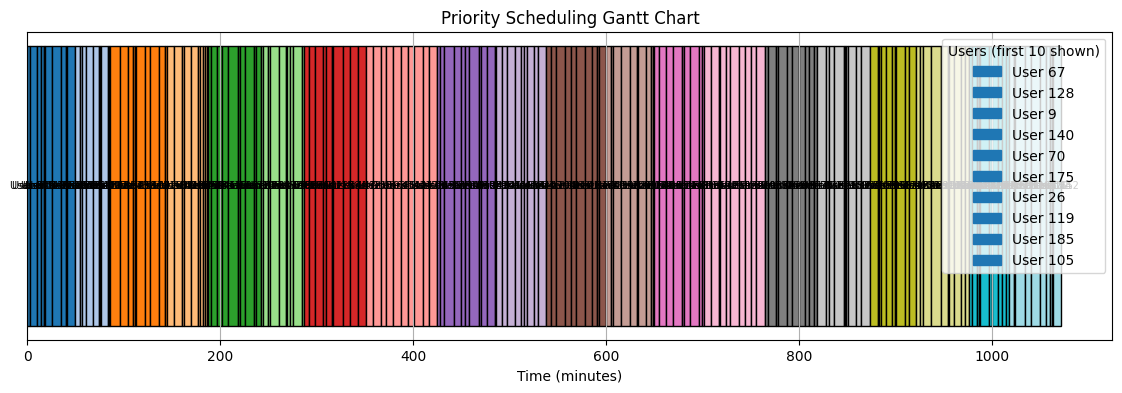

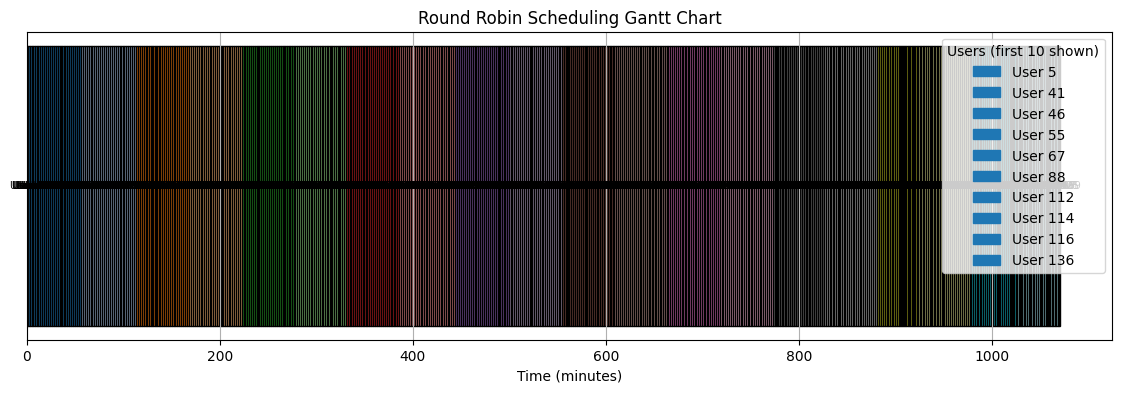

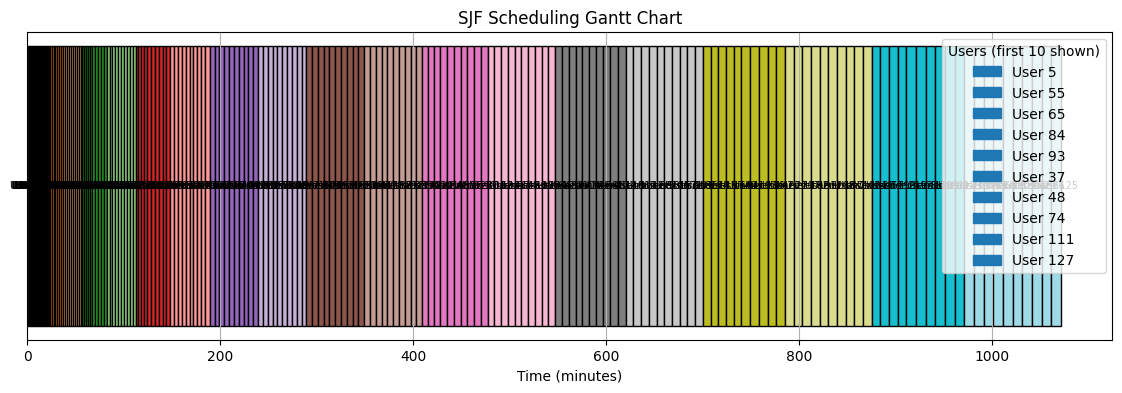

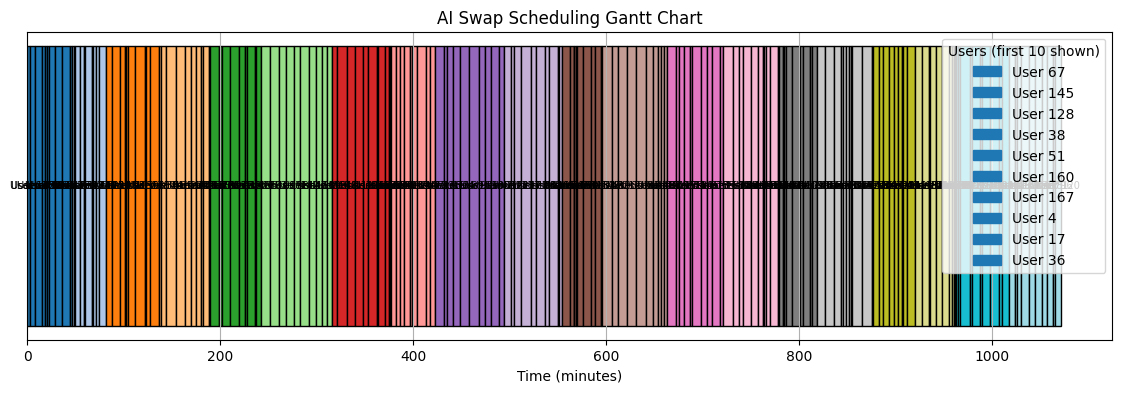

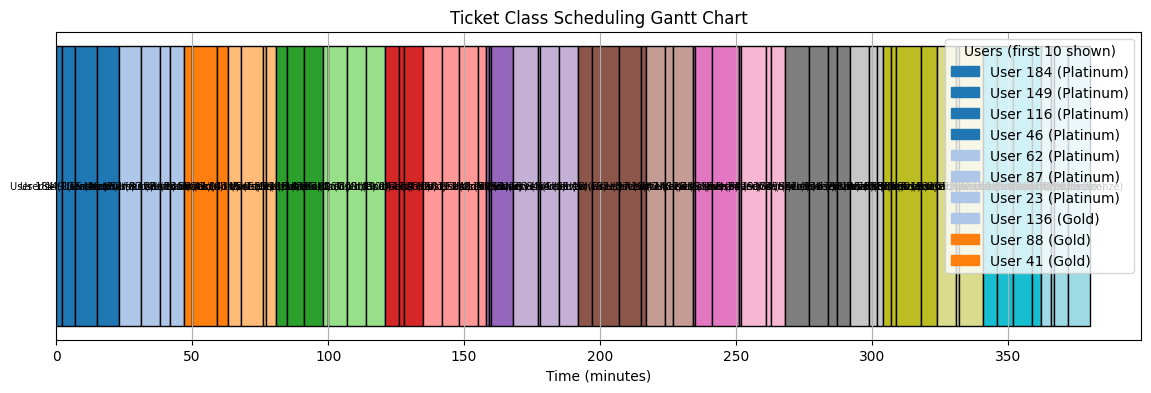


=== SCHEDULING TABLES ===

FCFS Scheduling Table (first 10 rows):
   UserID  ArrivalTime  BookingTime  AttendancePercentage  EngagementLevel  \
0       1            1            8             68.727006               23   
1       2           12            9             97.535715               74   
2       3            5            6             86.599697               71   
3       4            4            7             79.932924               35   
4       5            0            1             57.800932               37   
5       6           20            5             57.799726               83   
6       7           20            5             52.904181               98   
7       8            5           10             93.308807               88   
8       9            5            4             80.055751               98   
9      10           15            6             85.403629               24   

   VIPStatus TicketClassRequested  LoyaltyScore  CompletionTime  \
0      

In [6]:
import numpy as np
import pandas as pd
import heapq
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import time
from collections import defaultdict

np.random.seed(42)
num_users = 200

# Define ticket class limits
TICKET_CLASS_LIMITS = {
    'Platinum': 7,
    'Gold': 20,
    'Silver': 25,
    'Bronze': 20
}

# Define class priority order
CLASS_PRIORITY = ['Platinum', 'Gold', 'Silver', 'Bronze']
CLASS_WAIT_TIMEOUT = 2  # 10ms timeout before switching to next class

attendance_percentage = np.random.uniform(50, 100, size=num_users)
engagement_levels = np.random.randint(0, 101, size=num_users)
vip_status = np.random.choice([True, False], size=num_users, p=[0.2, 0.8])
loyalty_score = np.random.randint(0, 101, size=num_users)
arrival_time = np.random.randint(0, 21, size=num_users)
booking_time = np.random.randint(1, 11, size=num_users)

# Add ticket class requests
ticket_class_requests = np.random.choice(CLASS_PRIORITY, size=num_users, p=[0.15, 0.25, 0.35, 0.25])

users_df = pd.DataFrame({
    'UserID': range(1, num_users+1),
    'AttendancePercentage': attendance_percentage,
    'EngagementLevel': engagement_levels,
    'VIPStatus': vip_status,
    'LoyaltyScore': loyalty_score,
    'ArrivalTime': arrival_time,
    'BookingTime': booking_time,
    'TicketClassRequested': ticket_class_requests
})

users_df['PriorityScore'] = (
    users_df['AttendancePercentage'] * 0.4 +
    users_df['EngagementLevel'] * 0.3 +
    users_df['VIPStatus'].astype(int) * 20 +
    users_df['LoyaltyScore'] * 0.3
)

# Global variables for waitlist and cancellation management
class_waitlists = {cls: [] for cls in CLASS_PRIORITY}
confirmed_bookings = []
algorithm_results = {}

def detect_deadlock(ready_queue, current_time, max_wait_time=100):
    """Detect potential deadlock situations"""
    if not ready_queue:
        return False

    # Check if all processes have been waiting too long
    waiting_too_long = all(current_time - item[1] > max_wait_time for item in ready_queue)
    return waiting_too_long

def handle_deadlock(ready_queue, current_time):
    """Handle deadlock by aging priority or breaking ties"""
    print(f"Deadlock detected at time {current_time}. Applying aging mechanism.")
    # Age all processes by reducing their priority values (making them higher priority)
    aged_queue = []
    for item in ready_queue:
        if len(item) >= 4:
            priority, arrival, user_id, burst = item[:4]
            # Reduce priority value to increase actual priority
            aged_priority = priority + 10  # Aging factor
            aged_queue.append((aged_priority, arrival, user_id, burst))
        else:
            aged_queue.append(item)
    return aged_queue

def add_to_waitlist(user, ticket_class):
    """Add user to waitlist for specific ticket class"""
    class_waitlists[ticket_class].append(user)
    # Sort waitlist by priority score (descending)
    class_waitlists[ticket_class].sort(key=lambda x: x['PriorityScore'], reverse=True)

def simulate_cancellations(confirmed_bookings, cancellation_rate=0.15):
    """Simulate random cancellations from confirmed bookings"""
    if not confirmed_bookings:
        return []

    num_cancellations = max(1, int(len(confirmed_bookings) * cancellation_rate))
    cancelled_indices = np.random.choice(len(confirmed_bookings), num_cancellations, replace=False)

    cancelled_bookings = []
    for idx in sorted(cancelled_indices, reverse=True):
        cancelled_booking = confirmed_bookings.pop(idx)
        cancelled_bookings.append(cancelled_booking)

    return cancelled_bookings

def process_waitlist_after_cancellation(cancelled_bookings):
    """Process waitlist when tickets become available due to cancellations"""
    newly_confirmed = []

    for cancelled_booking in cancelled_bookings:
        if len(cancelled_booking) >= 4:  # Has ticket class info
            ticket_class = cancelled_booking[3]
            if class_waitlists[ticket_class]:
                # Get highest priority user from waitlist
                next_user = class_waitlists[ticket_class].pop(0)
                newly_confirmed.append((next_user['UserID'], cancelled_booking[1],
                                     cancelled_booking[2], ticket_class))
                print(f"User {next_user['UserID']} moved from waitlist to confirmed for {ticket_class} class")

    return newly_confirmed

def ticket_class_scheduling(users):
    """
    Simulate booking for different ticket classes with priority-based allocation and waitlist management
    """
    try:
        users_sorted = users.sort_values(by=['ArrivalTime', 'UserID']).reset_index(drop=True)

        # Initialize class counters and queues
        class_sold = {cls: 0 for cls in CLASS_PRIORITY}
        class_queues = {cls: [] for cls in CLASS_PRIORITY}
        schedule = []
        current_time = 0
        current_class_index = 0
        last_booking_time = {cls: 0 for cls in CLASS_PRIORITY}
        deadlock_counter = 0
        max_iterations = len(users_sorted) * 10  # Prevent infinite loops

        # Separate users by requested class
        for _, user in users_sorted.iterrows():
            class_queues[user['TicketClassRequested']].append(user)

        # Sort each class queue by arrival time and priority
        for cls in CLASS_PRIORITY:
            class_queues[cls] = sorted(class_queues[cls], key=lambda x: (x['ArrivalTime'], -x['PriorityScore']))

        total_users_processed = 0
        total_users = len(users_sorted)
        iteration_count = 0

        while total_users_processed < total_users and iteration_count < max_iterations:
            iteration_count += 1
            current_class = CLASS_PRIORITY[current_class_index]

            # Deadlock detection
            remaining_users = [user for queue in class_queues.values() for user in queue]
            if remaining_users and iteration_count > len(users_sorted) * 2:
                if detect_deadlock([(0, user['ArrivalTime'], user['UserID']) for user in remaining_users], current_time):
                    print("Deadlock detected in ticket class scheduling. Applying resolution...")
                    # Force process the oldest waiting user
                    oldest_user = min(remaining_users, key=lambda x: x['ArrivalTime'])
                    for cls in CLASS_PRIORITY:
                        if oldest_user in class_queues[cls]:
                            if class_sold[cls] < TICKET_CLASS_LIMITS[cls]:
                                start_time = max(current_time, oldest_user['ArrivalTime'])
                                finish_time = start_time + oldest_user['BookingTime']
                                schedule.append((oldest_user['UserID'], start_time, finish_time, cls))
                                class_sold[cls] += 1
                                class_queues[cls].remove(oldest_user)
                                current_time = finish_time
                                total_users_processed += 1
                            else:
                                # Add to waitlist
                                add_to_waitlist(oldest_user, cls)
                                class_queues[cls].remove(oldest_user)
                                total_users_processed += 1
                            break
                    continue

            # Check if current class has available slots and pending requests
            if (class_sold[current_class] < TICKET_CLASS_LIMITS[current_class] and
                class_queues[current_class]):

                # Find next user who has arrived
                user_scheduled = False
                for i, user in enumerate(class_queues[current_class]):
                    if user['ArrivalTime'] <= current_time:
                        # Schedule this user
                        start_time = max(current_time, user['ArrivalTime'])
                        finish_time = start_time + user['BookingTime']

                        schedule.append((user['UserID'], start_time, finish_time, current_class))

                        class_sold[current_class] += 1
                        class_queues[current_class].pop(i)
                        last_booking_time[current_class] = current_time
                        current_time = finish_time
                        total_users_processed += 1
                        user_scheduled = True
                        break

                if not user_scheduled:
                    # No user available for current class, check timeout
                    if current_time - last_booking_time[current_class] >= CLASS_WAIT_TIMEOUT:
                        # Switch to next class due to timeout
                        current_class_index = (current_class_index + 1) % len(CLASS_PRIORITY)
                    else:
                        # Wait for next user arrival
                        next_arrival = min([user['ArrivalTime'] for queue in class_queues.values()
                                          for user in queue if user['ArrivalTime'] > current_time],
                                         default=current_time + 1)
                        current_time = next_arrival
            else:
                # Current class is full or empty
                if class_queues[current_class]:  # Users waiting but class is full
                    # Add remaining users to waitlist
                    for user in class_queues[current_class]:
                        add_to_waitlist(user, current_class)
                        total_users_processed += 1
                    class_queues[current_class] = []

                # Move to next class
                current_class_index = (current_class_index + 1) % len(CLASS_PRIORITY)

                # If all classes are checked and no progress, advance time
                if current_class_index == 0:
                    remaining_users = [user for queue in class_queues.values() for user in queue]
                    if remaining_users:
                        next_arrival = min([user['ArrivalTime'] for user in remaining_users
                                          if user['ArrivalTime'] > current_time],
                                         default=current_time + 1)
                        current_time = next_arrival
                    else:
                        break

        return schedule, class_sold

    except Exception as e:
        print(f"Ticket Class Scheduling FAILED: {str(e)}")
        return [], {cls: 0 for cls in CLASS_PRIORITY}

def fcfs_scheduling(users):
    try:
        users_sorted = users.sort_values(by=['ArrivalTime', 'UserID']).reset_index(drop=True)
        start_time = 0
        schedule = []
        for _, row in users_sorted.iterrows():
            if start_time < row['ArrivalTime']:
                start_time = row['ArrivalTime']
            finish_time = start_time + row['BookingTime']
            schedule.append((row['UserID'], start_time, finish_time))
            start_time = finish_time
        return schedule
    except Exception as e:
        print(f"FCFS Scheduling FAILED: {str(e)}")
        return []

def priority_scheduling(users):
    try:
        n = len(users)
        completed = 0
        current_time = 0
        schedule = []
        ready_queue = []
        i = 0
        users_sorted = users.sort_values(by=['ArrivalTime', 'UserID']).reset_index(drop=True)
        max_iterations = n * 10
        iteration_count = 0

        while completed < n and iteration_count < max_iterations:
            iteration_count += 1

            while i < n and users_sorted.loc[i, 'ArrivalTime'] <= current_time:
                heapq.heappush(ready_queue, (-users_sorted.loc[i, 'PriorityScore'],
                                           users_sorted.loc[i, 'ArrivalTime'],
                                           users_sorted.loc[i, 'UserID'],
                                           users_sorted.loc[i, 'BookingTime']))
                i += 1

            if ready_queue:
                # Check for deadlock
                if detect_deadlock(ready_queue, current_time):
                    ready_queue = handle_deadlock(ready_queue, current_time)
                    heapq.heapify(ready_queue)

                priority, arrival, user_id, burst = heapq.heappop(ready_queue)
                start_time = current_time
                finish_time = start_time + burst
                schedule.append((user_id, start_time, finish_time))
                current_time = finish_time
                completed += 1
            else:
                if i < n:
                    current_time = users_sorted.loc[i, 'ArrivalTime']
                else:
                    break

        if completed < n:
            print(f"Priority Scheduling: Only completed {completed}/{n} users")

        return schedule
    except Exception as e:
        print(f"Priority Scheduling FAILED: {str(e)}")
        return []

def round_robin_scheduling(users, time_quantum=2):
    try:
        users_sorted = users.sort_values(by=['ArrivalTime', 'UserID']).reset_index(drop=True)
        n = len(users_sorted)
        remaining_time = users_sorted['BookingTime'].tolist()
        arrival_time = users_sorted['ArrivalTime'].tolist()
        user_ids = users_sorted['UserID'].tolist()
        current_time = 0
        schedule = []
        queue = []
        i = 0
        completed = 0
        max_iterations = n * 20
        iteration_count = 0

        while completed < n and iteration_count < max_iterations:
            iteration_count += 1

            while i < n and arrival_time[i] <= current_time:
                queue.append(i)
                i += 1

            if not queue:
                if i < n:
                    current_time = arrival_time[i]
                    continue
                else:
                    break

            # Deadlock detection for round robin
            if len(queue) > 0 and iteration_count > n * 5:
                if all(remaining_time[idx] > 0 for idx in queue):
                    print("Potential deadlock in Round Robin. Forcing completion...")
                    # Force complete one process
                    idx = queue[0]
                    start_time = current_time
                    exec_time = remaining_time[idx]
                    remaining_time[idx] = 0
                    current_time += exec_time
                    finish_time = current_time
                    schedule.append((user_ids[idx], start_time, finish_time))
                    queue.pop(0)
                    completed += 1
                    continue

            idx = queue.pop(0)
            start_time = current_time
            exec_time = min(time_quantum, remaining_time[idx])
            remaining_time[idx] -= exec_time
            current_time += exec_time
            finish_time = current_time
            schedule.append((user_ids[idx], start_time, finish_time))

            while i < n and arrival_time[i] <= current_time:
                queue.append(i)
                i += 1

            if remaining_time[idx] > 0:
                queue.append(idx)
            else:
                completed += 1

        return schedule
    except Exception as e:
        print(f"Round Robin Scheduling FAILED: {str(e)}")
        return []

def shortest_booking_time_first(users):
    try:
        users_sorted = users.sort_values(by=['ArrivalTime', 'UserID']).reset_index(drop=True)
        n = len(users_sorted)
        completed = 0
        current_time = 0
        schedule = []
        ready_queue = []
        i = 0
        max_iterations = n * 10
        iteration_count = 0

        while completed < n and iteration_count < max_iterations:
            iteration_count += 1

            while i < n and users_sorted.loc[i, 'ArrivalTime'] <= current_time:
                heapq.heappush(ready_queue, (users_sorted.loc[i, 'BookingTime'],
                                           users_sorted.loc[i, 'ArrivalTime'],
                                           users_sorted.loc[i, 'UserID']))
                i += 1

            if ready_queue:
                # Check for deadlock
                if detect_deadlock(ready_queue, current_time):
                    print("Deadlock detected in SJF. Applying resolution...")
                    ready_queue = handle_deadlock(ready_queue, current_time)
                    heapq.heapify(ready_queue)

                burst, arrival, user_id = heapq.heappop(ready_queue)
                start_time = current_time
                finish_time = start_time + burst
                schedule.append((user_id, start_time, finish_time))
                current_time = finish_time
                completed += 1
            else:
                if i < n:
                    current_time = users_sorted.loc[i, 'ArrivalTime']
                else:
                    break

        return schedule
    except Exception as e:
        print(f"SJF Scheduling FAILED: {str(e)}")
        return []

def ai_swap_confirmation_waitlist(users, confirmation_limit=50):
    try:
        users_sorted = users.sort_values(by=['ArrivalTime', 'UserID']).reset_index(drop=True)
        confirmation_list = users_sorted.iloc[:confirmation_limit].copy()
        waiting_list = users_sorted.iloc[confirmation_limit:].copy()

        waiting_sorted = waiting_list.sort_values(by='PriorityScore', ascending=False)
        confirmation_sorted = confirmation_list.sort_values(by='PriorityScore')

        swaps = []
        max_swaps = min(len(waiting_list), len(confirmation_list))
        swap_count = 0

        for idx_wait, wait_row in waiting_sorted.iterrows():
            if swap_count >= max_swaps:
                break
            for idx_conf, conf_row in confirmation_sorted.iterrows():
                if wait_row['PriorityScore'] > conf_row['PriorityScore']:
                    confirmation_list.loc[idx_conf], waiting_list.loc[idx_wait] = waiting_list.loc[idx_wait].copy(), confirmation_list.loc[idx_conf].copy()
                    swaps.append((conf_row['UserID'], wait_row['UserID']))
                    confirmation_sorted = confirmation_list.sort_values(by='PriorityScore')
                    waiting_sorted = waiting_list.sort_values(by='PriorityScore', ascending=False)
                    swap_count += 1
                    break

        confirmation_schedule = fcfs_scheduling(confirmation_list)
        last_finish = max([finish for _, _, finish in confirmation_schedule]) if confirmation_schedule else 0
        waiting_schedule = []
        start_time = last_finish
        for _, row in waiting_list.iterrows():
            if start_time < row['ArrivalTime']:
                start_time = row['ArrivalTime']
            finish_time = start_time + row['BookingTime']
            waiting_schedule.append((row['UserID'], start_time, finish_time))
            start_time = finish_time

        full_schedule = confirmation_schedule + waiting_schedule
        return full_schedule, swaps
    except Exception as e:
        print(f"AI Swap Scheduling FAILED: {str(e)}")
        return [], []

def calculate_performance_metrics(schedule, users):
    """Calculate performance metrics for scheduling algorithms"""
    if not schedule:
        return {
            'avg_waiting_time': float('inf'),
            'avg_turnaround_time': float('inf'),
            'total_completion_time': float('inf'),
            'throughput': 0
        }

    try:
        if len(schedule[0]) == 4:  # Ticket class schedule
            schedule_df = pd.DataFrame(schedule, columns=['UserID', 'StartTime', 'FinishTime', 'TicketClass'])
        else:  # Regular schedule
            schedule_df = pd.DataFrame(schedule, columns=['UserID', 'StartTime', 'FinishTime'])

        merged = pd.merge(users, schedule_df, on='UserID', how='inner')
        if merged.empty:
            return {
                'avg_waiting_time': float('inf'),
                'avg_turnaround_time': float('inf'),
                'total_completion_time': float('inf'),
                'throughput': 0
            }

        merged['TurnAroundTime'] = merged['FinishTime'] - merged['ArrivalTime']
        merged['WaitingTime'] = merged['TurnAroundTime'] - merged['BookingTime']

        return {
            'avg_waiting_time': merged['WaitingTime'].mean(),
            'avg_turnaround_time': merged['TurnAroundTime'].mean(),
            'total_completion_time': merged['FinishTime'].max(),
            'throughput': len(merged) / merged['FinishTime'].max() if merged['FinishTime'].max() > 0 else 0
        }
    except Exception as e:
        print(f"Error calculating metrics: {str(e)}")
        return {
            'avg_waiting_time': float('inf'),
            'avg_turnaround_time': float('inf'),
            'total_completion_time': float('inf'),
            'throughput': 0
        }

# Execute all scheduling algorithms with error handling
print("=== EXECUTING SCHEDULING ALGORITHMS ===\n")

algorithms = {
    'FCFS': lambda: fcfs_scheduling(users_df),
    'Priority': lambda: priority_scheduling(users_df),
    'Round Robin': lambda: round_robin_scheduling(users_df, time_quantum=2),
    'SJF': lambda: shortest_booking_time_first(users_df),
    'AI Swap': lambda: ai_swap_confirmation_waitlist(users_df, confirmation_limit=50),
    'Ticket Class': lambda: ticket_class_scheduling(users_df)
}

# Execute algorithms and collect results
for name, func in algorithms.items():
    try:
        print(f"Executing {name} Scheduling...")
        if name == 'AI Swap':
            result, swaps = func()
            algorithm_results[name] = {'schedule': result, 'swaps': swaps}
        elif name == 'Ticket Class':
            result, class_allocation = func()
            algorithm_results[name] = {'schedule': result, 'class_allocation': class_allocation}
            confirmed_bookings.extend(result)  # Store for cancellation simulation
        else:
            result = func()
            algorithm_results[name] = {'schedule': result}

        if not result:
            print(f"{name} Scheduling returned empty schedule!")
        else:
            print(f"{name} Scheduling completed successfully with {len(result)} bookings")

    except Exception as e:
        print(f"{name} Scheduling FAILED with error: {str(e)}")
        algorithm_results[name] = {'schedule': [], 'error': str(e)}

print("\n=== SIMULATING CANCELLATIONS ===")
if confirmed_bookings:
    cancelled_bookings = simulate_cancellations(confirmed_bookings)
    print(f"Simulated {len(cancelled_bookings)} cancellations")

    newly_confirmed = process_waitlist_after_cancellation(cancelled_bookings)
    print(f"Processed {len(newly_confirmed)} users from waitlist")

    # Update confirmed bookings
    confirmed_bookings.extend(newly_confirmed)

print("\n=== WAITLIST STATUS ===")
for cls in CLASS_PRIORITY:
    print(f"{cls} Waitlist: {len(class_waitlists[cls])} users")
    if class_waitlists[cls]:
        top_users = class_waitlists[cls][:3]  # Show top 3
        for user in top_users:
            print(f"  - User {user['UserID']} (Priority: {user['PriorityScore']:.2f})")

# Calculate performance metrics and find best algorithm
print("\n=== PERFORMANCE ANALYSIS ===")
performance_results = {}

for name, data in algorithm_results.items():
    if 'error' in data:
        print(f"{name}: FAILED - {data['error']}")
        continue

    schedule = data['schedule']
    metrics = calculate_performance_metrics(schedule, users_df)
    performance_results[name] = metrics

    print(f"\n{name} Scheduling Metrics:")
    print(f"  Average Waiting Time: {metrics['avg_waiting_time']:.2f}")
    print(f"  Average Turnaround Time: {metrics['avg_turnaround_time']:.2f}")
    print(f"  Total Completion Time: {metrics['total_completion_time']:.2f}")
    print(f"  Throughput: {metrics['throughput']:.4f}")

# Determine best algorithm
print("\n=== BEST SCHEDULING ALGORITHM ===")
if performance_results:
    # Score algorithms based on multiple criteria (lower is better for times, higher for throughput)
    algorithm_scores = {}

    for name, metrics in performance_results.items():
        if metrics['avg_waiting_time'] == float('inf'):
            algorithm_scores[name] = float('inf')
            continue

        # Weighted scoring: waiting time (40%), turnaround time (30%), throughput (30%)
        score = (
            metrics['avg_waiting_time'] * 0.4 +
            metrics['avg_turnaround_time'] * 0.3 -
            metrics['throughput'] * 100 * 0.3  # Negative because higher throughput is better
        )
        algorithm_scores[name] = score

    best_algorithm = min(algorithm_scores.items(), key=lambda x: x[1])
    print(f"BEST ALGORITHM: {best_algorithm[0]} (Score: {best_algorithm[1]:.2f})")

    # Show ranking
    print("\nAlgorithm Ranking (best to worst):")
    sorted_algorithms = sorted(algorithm_scores.items(), key=lambda x: x[1])
    for i, (name, score) in enumerate(sorted_algorithms, 1):
        if score == float('inf'):
            print(f"{i}. {name}: FAILED")
        else:
            print(f"{i}. {name}: {score:.2f}")
else:
    print("No algorithms completed successfully!")

# Generate visualizations for successful algorithms
def plot_gantt_chart(schedule, title):
    if not schedule:
        print(f"Cannot plot {title}: Empty schedule")
        return

    fig, ax = plt.subplots(figsize=(14, 4))
    colors = plt.cm.get_cmap('tab20', len(schedule))
    for i, item in enumerate(schedule):
        if len(item) == 4:  # Ticket class schedule
            user_id, start, finish, ticket_class = item
            label = f'User {user_id} ({ticket_class})'
        else:  # Regular schedule
            user_id, start, finish = item
            label = f'User {user_id}'

        ax.barh(y=1, width=finish-start, left=start, height=0.3, color=colors(i), edgecolor='black')
        ax.text(x=start + (finish-start)/2, y=1, s=label, va='center', ha='center', color='black', fontsize=7)

    ax.set_xlabel('Time (minutes)')
    ax.set_yticks([])
    ax.set_title(title)
    ax.grid(True, axis='x')

    patches = []
    for i, item in enumerate(schedule[:10]):
        if len(item) == 4:
            user_id, _, _, ticket_class = item
            label = f'User {user_id} ({ticket_class})'
        else:
            user_id, _, _ = item
            label = f'User {user_id}'
        patches.append(mpatches.Patch(color=colors(i), label=label))

    ax.legend(handles=patches, title='Users (first 10 shown)')
    plt.show()

# Plot Gantt charts for successful algorithms
for name, data in algorithm_results.items():
    if 'error' not in data and data['schedule']:
        plot_gantt_chart(data['schedule'], f'{name} Scheduling Gantt Chart')

def generate_schedule_table(users, schedule):
    if not schedule:
        return pd.DataFrame()

    if len(schedule[0]) == 4:  # Ticket class schedule
        schedule_df = pd.DataFrame(schedule, columns=['UserID', 'StartTime', 'FinishTime', 'TicketClass'])
    else:  # Regular schedule
        schedule_df = pd.DataFrame(schedule, columns=['UserID', 'StartTime', 'FinishTime'])

    merged = pd.merge(users, schedule_df, on='UserID')
    merged['CompletionTime'] = merged['FinishTime']
    merged['TurnAroundTime'] = merged['CompletionTime'] - merged['ArrivalTime']
    merged['WaitingTime'] = merged['TurnAroundTime'] - merged['BookingTime']

    base_columns = ['UserID', 'ArrivalTime', 'BookingTime', 'AttendancePercentage', 'EngagementLevel', 'VIPStatus', 'LoyaltyScore', 'CompletionTime', 'TurnAroundTime', 'WaitingTime']
    if 'TicketClass' in merged.columns:
        base_columns.insert(-3, 'TicketClass')
    if 'TicketClassRequested' in merged.columns:
        base_columns.insert(-4, 'TicketClassRequested')

    return merged[base_columns]

# Generate tables for successful algorithms
print("\n=== SCHEDULING TABLES ===")
for name, data in algorithm_results.items():
    if 'error' not in data and data['schedule']:
        table = generate_schedule_table(users_df, data['schedule'])
        if not table.empty:
            print(f"\n{name} Scheduling Table (first 10 rows):")
            print(table.head(10))

# Print additional information
if 'AI Swap' in algorithm_results and 'swaps' in algorithm_results['AI Swap']:
    print(f"\nAI-based swaps between confirmation and waitlist:")
    swaps = algorithm_results['AI Swap']['swaps']
    print(swaps[:10] if swaps else "No swaps performed")

if 'Ticket Class' in algorithm_results and 'class_allocation' in algorithm_results['Ticket Class']:
    print(f"\nTicket Class Allocation Summary:")
    class_allocation = algorithm_results['Ticket Class']['class_allocation']
    for cls in CLASS_PRIORITY:
        print(f"{cls}: {class_allocation[cls]}/{TICKET_CLASS_LIMITS[cls]} tickets sold")

print(f"\nUser Ticket Class Requests:")
print(users_df[['UserID', 'TicketClassRequested']].head(10))

print(f"\n=== EXECUTION COMPLETED ===")


# **Wait Listing with Scheduling Algorithms FCFS, RR, Priority Scheduling, Shortest Booking Time**

<ipython-input-4-dc62b2386637>:134: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(schedule))


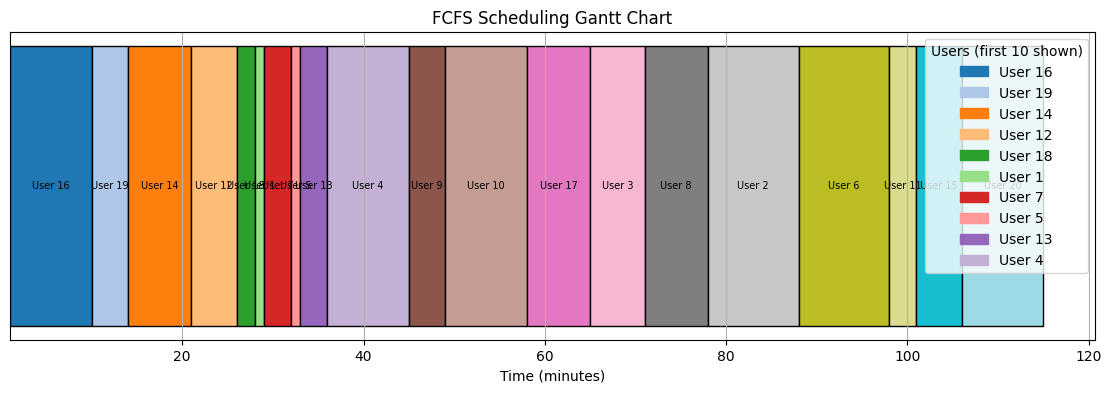

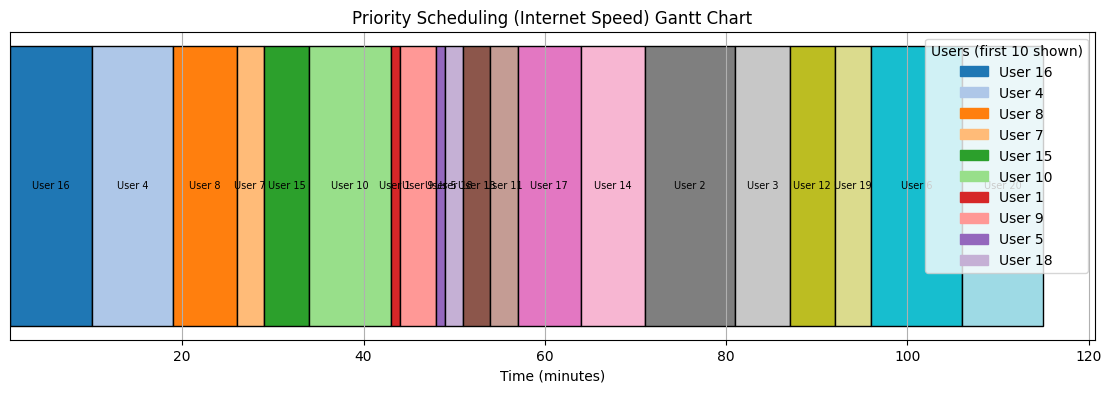

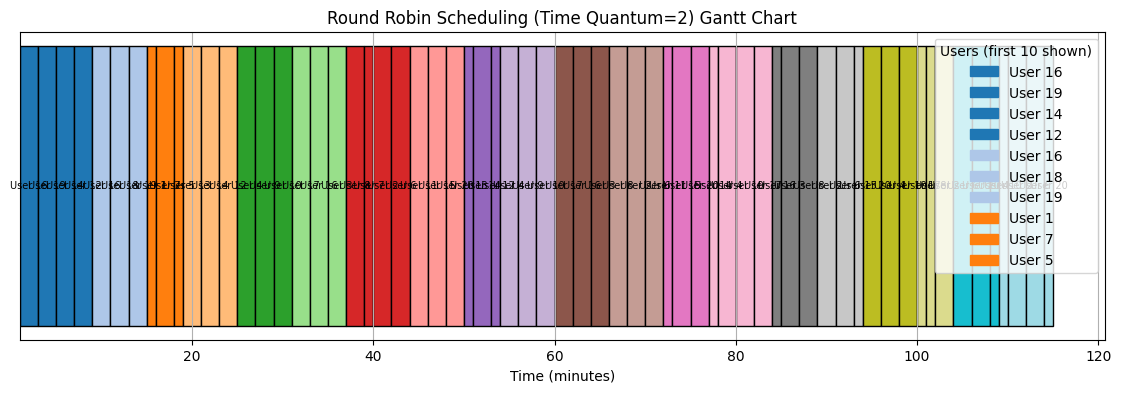

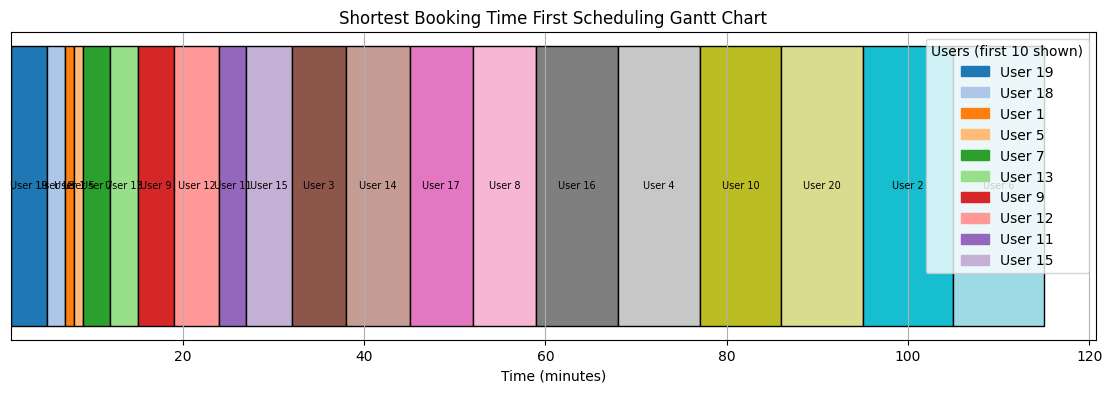

FCFS Table: 
   UserID  ArrivalTime  BookingTime  InternetSpeed  CompletionTime  \
0       1            6            1             60              29   
1       2           19           10             14              88   
2       3           14            6              9              71   
3       4           10            9             90              45   
4       5            7            1             53              33   
5       6           20           10              2              98   
6       7            6            3             84              32   
7       8           18            7             92              78   
8       9           10            4             60              49   
9      10           10            9             71              58   

   TurnAroundTime  WaitingTime  
0              23           22  
1              69           59  
2              57           51  
3              35           26  
4              26           25  
5              78 

In [ ]:
import numpy as np
import pandas as pd
import heapq
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns


np.random.seed(42)
num_users = 20
arrival_time = np.random.randint(0, 21, size=num_users)
booking_time = np.random.randint(1, 11, size=num_users)
internet_speed = np.random.randint(1, 101, size=num_users)

users_df = pd.DataFrame({
    'UserID': range(1, num_users+1),
    'ArrivalTime': arrival_time,
    'BookingTime': booking_time,
    'InternetSpeed': internet_speed
})



def fcfs_scheduling(users):
    users_sorted = users.sort_values(by=['ArrivalTime', 'UserID']).reset_index(drop=True)
    start_time = 0
    schedule = []
    for _, row in users_sorted.iterrows():
        if start_time < row['ArrivalTime']:
            start_time = row['ArrivalTime']
        finish_time = start_time + row['BookingTime']
        schedule.append((row['UserID'], start_time, finish_time))
        start_time = finish_time
    return schedule

def priority_scheduling(users):
    users_sorted = users.sort_values(by=['ArrivalTime', 'UserID']).reset_index(drop=True)
    n = len(users_sorted)
    completed = 0
    current_time = 0
    schedule = []
    ready_queue = []
    i = 0
    while completed < n:
        while i < n and users_sorted.loc[i, 'ArrivalTime'] <= current_time:
            heapq.heappush(ready_queue, (-users_sorted.loc[i, 'InternetSpeed'], users_sorted.loc[i, 'ArrivalTime'], users_sorted.loc[i, 'UserID'], users_sorted.loc[i, 'BookingTime']))
            i += 1
        if ready_queue:
            speed, arrival, user_id, burst = heapq.heappop(ready_queue)
            start_time = current_time
            finish_time = start_time + burst
            schedule.append((user_id, start_time, finish_time))
            current_time = finish_time
            completed += 1
        else:
            if i < n:
                current_time = users_sorted.loc[i, 'ArrivalTime']
            else:
                break
    return schedule

def round_robin_scheduling(users, time_quantum=2):
    users_sorted = users.sort_values(by=['ArrivalTime', 'UserID']).reset_index(drop=True)
    n = len(users_sorted)
    remaining_time = users_sorted['BookingTime'].tolist()
    arrival_time = users_sorted['ArrivalTime'].tolist()
    user_ids = users_sorted['UserID'].tolist()
    current_time = 0
    schedule = []
    queue = []
    i = 0
    completed = 0
    while completed < n:
        while i < n and arrival_time[i] <= current_time:
            queue.append(i)
            i += 1
        if not queue:
            if i < n:
                current_time = arrival_time[i]
                continue
            else:
                break
        idx = queue.pop(0)
        start_time = current_time
        exec_time = min(time_quantum, remaining_time[idx])
        remaining_time[idx] -= exec_time
        current_time += exec_time
        finish_time = current_time
        schedule.append((user_ids[idx], start_time, finish_time))
        while i < n and arrival_time[i] <= current_time:
            queue.append(i)
            i += 1
        if remaining_time[idx] > 0:
            queue.append(idx)
        else:
            completed += 1
    return schedule

def shortest_booking_time_first(users):
    users_sorted = users.sort_values(by=['ArrivalTime', 'UserID']).reset_index(drop=True)
    n = len(users_sorted)
    completed = 0
    current_time = 0
    schedule = []
    ready_queue = []
    i = 0
    while completed < n:
        while i < n and users_sorted.loc[i, 'ArrivalTime'] <= current_time:
            heapq.heappush(ready_queue, (users_sorted.loc[i, 'BookingTime'], users_sorted.loc[i, 'ArrivalTime'], users_sorted.loc[i, 'UserID']))
            i += 1
        if ready_queue:
            burst, arrival, user_id = heapq.heappop(ready_queue)
            start_time = current_time
            finish_time = start_time + burst
            schedule.append((user_id, start_time, finish_time))
            current_time = finish_time
            completed += 1
        else:
            if i < n:
                current_time = users_sorted.loc[i, 'ArrivalTime']
            else:
                break
    return schedule


fcfs_schedule = fcfs_scheduling(users_df)
priority_schedule = priority_scheduling(users_df)
rr_schedule = round_robin_scheduling(users_df, time_quantum=2)
shortest_schedule = shortest_booking_time_first(users_df)


def plot_gantt_chart(schedule, title):
    fig, ax = plt.subplots(figsize=(14, 4))
    colors = plt.cm.get_cmap('tab20', len(schedule))
    for i, (user_id, start, finish) in enumerate(schedule):
        ax.barh(y=1, width=finish-start, left=start, height=0.3, color=colors(i), edgecolor='black')
        ax.text(x=start + (finish-start)/2, y=1, s=f'User {user_id}', va='center', ha='center', color='black', fontsize=7)
    ax.set_xlabel('Time (minutes)')
    ax.set_yticks([])
    ax.set_title(title)
    ax.grid(True, axis='x')
    patches = [mpatches.Patch(color=colors(i), label=f'User {user_id}') for i, (user_id, _, _) in enumerate(schedule)]
    ax.legend(handles=patches[:10], title='Users (first 10 shown)')
    plt.show()


plot_gantt_chart(fcfs_schedule, 'FCFS Scheduling Gantt Chart')
plot_gantt_chart(priority_schedule, 'Priority Scheduling (Internet Speed) Gantt Chart')
plot_gantt_chart(rr_schedule, 'Round Robin Scheduling (Time Quantum=2) Gantt Chart')
plot_gantt_chart(shortest_schedule, 'Shortest Booking Time First Scheduling Gantt Chart')


def generate_schedule_table(users, schedule):
    # users: original dataframe
    # schedule: list of tuples (UserID, start_time, finish_time)
    schedule_df = pd.DataFrame(schedule, columns=['UserID', 'StartTime', 'FinishTime'])
    merged = pd.merge(users, schedule_df, on='UserID')
    merged['CompletionTime'] = merged['FinishTime']
    merged['TurnAroundTime'] = merged['CompletionTime'] - merged['ArrivalTime']
    merged['WaitingTime'] = merged['TurnAroundTime'] - merged['BookingTime']
    return merged[['UserID', 'ArrivalTime', 'BookingTime', 'InternetSpeed', 'CompletionTime', 'TurnAroundTime', 'WaitingTime']]


fcfs_table = generate_schedule_table(users_df, fcfs_schedule)
print("FCFS Table: ")
print(fcfs_table.head(10))
priority_table = generate_schedule_table(users_df, priority_schedule)
print("Priority Table: ")
print(priority_table.head(10))
rr_table = generate_schedule_table(users_df, rr_schedule)
print("Round Robin Table: ")
print(rr_table.head(10))
shortest_table = generate_schedule_table(users_df, shortest_schedule)
print("Shortest Booking Table: ")
print(shortest_table.head(10))
